# DMS single protein by position

Here I train a separate model for each dms experiment and use it to predict unseen mutations in the same protein. I use different positions along the protein in validation and training.

## Notes on hyperparam tuning

- max_depth
    - not so clear, 6 seems good
    - I tried 2, 4, 6, 8, 10
    - 4 and 8 seem good without whith 6 lower (surprisingly consistently)
    - 2 and 10 are lower
    - there is not really a trend, now 3 seems good
    - I want to see what happens after 10
    - I fix on 6
- min_child_weigth
    - seems to not to be important
    - I tried 0, 0.5, 1, 5, 10 and 0 and 1 are best, no strong pattern
    - 0 and 1 work well, I fix it to 1
    - Values around 1 seem good but it is not so relevant
    - Fix at 0.5
- subsample
    - 0.5 is best, followed by 0.1 and worst is 1
    - I tried 0.1, 0.3, 0.5, 0.8 and 0.5 is best
    - Fix at 0.4
- colsample_bytree
    - 0.5 is best, followed by 1 and 0.1 is worst
    - 0.3 is best, decreasing towards bigger values (tested until 1)
    - maybe I am overfitting the validation? (very good selection of features at convenient rounds)
    - 0.4 seems best
    - Very low values are at the very top, but likely overfitting
    - I try a small range around 0.4
    - Fix at 0.5
- eta
    - need to try 1e-2 to 1e-1 detailed (1e-1 is decisively best)
    - 3e-2 is best, decreasing towards bigger values (tested until 1e-1)
    - 1e-2 and 2e-2 seem good, use these 2
    - 0.01 better than 0.02
    - Fixing on 0.014
- gamma
    - Around 0.5 seem best, tried 0-100
    - Retry with 0.1-1
    - Fix at 0.3
- lambda
    - Above 5 is bad
    - No need very small (<0.001), just put a 0
    - Need to see better the range 0.001-5
    - Fix at 0.1
- alpha
    - Seems not so important if <1 (above is bad)
    - Retry 0-1
    - Retry 0-0.5
    - Fix at 0.08
- tree_method
    - I use hist
- num_rounds
    - higher is better, can increase after fixing the other hyperparams

## Visualizing the random search results

Here I visualize the results of the random search. First I load the dump that I obtained with my script and load the needed libraries.

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
import pandas as pd

dump_in = joblib.load('/home/saul/master_thesis_work/processing/dms/single_protein_models/by_position/random_search_20210427-123247.joblib.xz')
corr_df = dump_in['data']
params_random_search = [el[1] for el in dump_in['params']]
del dump_in
len(corr_df)

3

### Proportion of hyperparameters in the top N combinations

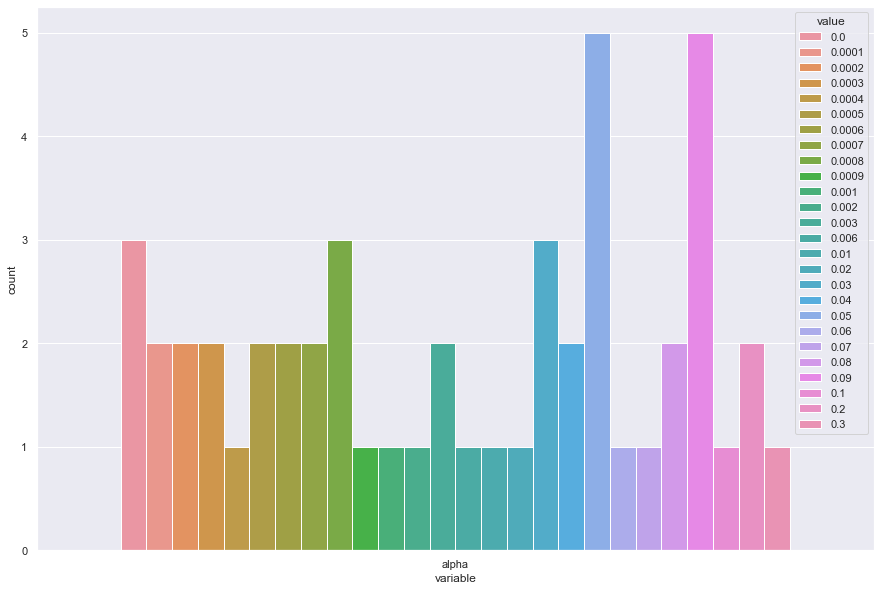

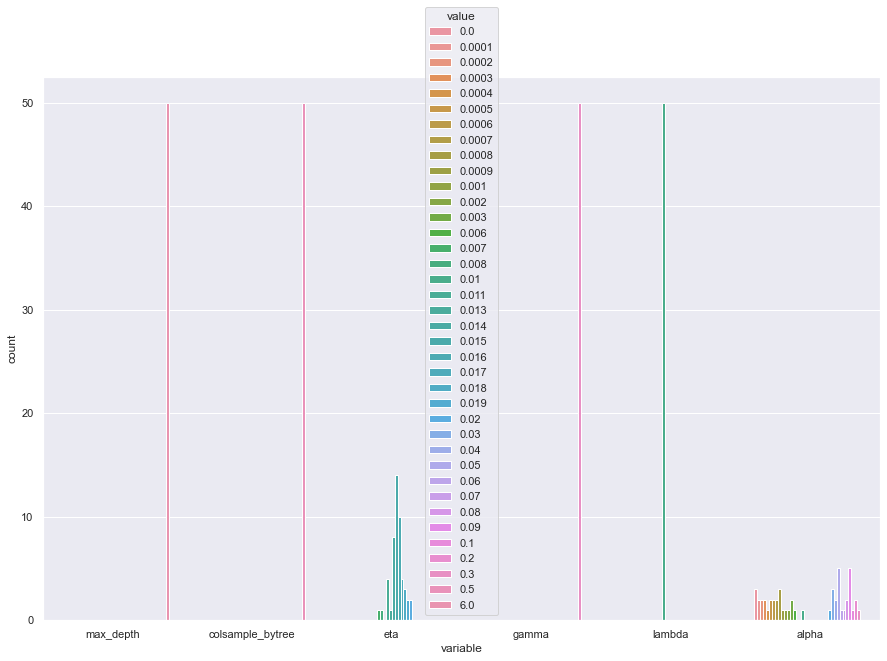

In [29]:
hyperparam_df = pd.DataFrame()
for name in corr_df.iloc[:50].index:
    param_index = int(name.split('_')[1])
    curr_params = pd.DataFrame(params_random_search[param_index], index=[param_index])
    hyperparam_df = hyperparam_df.append(curr_params)
hyperparam_df.drop(['objective', 'tree_method', 'nthread', 'num_rounds', 'min_child_weight', 'subsample'], axis=1, inplace=True)

melted_df = hyperparam_df.melt()
var_to_show = 'alpha'
plt.figure(figsize=(15,10))
sns.countplot(data=melted_df[melted_df.variable == var_to_show], x='variable', hue='value')
plt.show()
plt.figure(figsize=(15,10))
sns.countplot(data=melted_df, x='variable', hue='value')
plt.show()

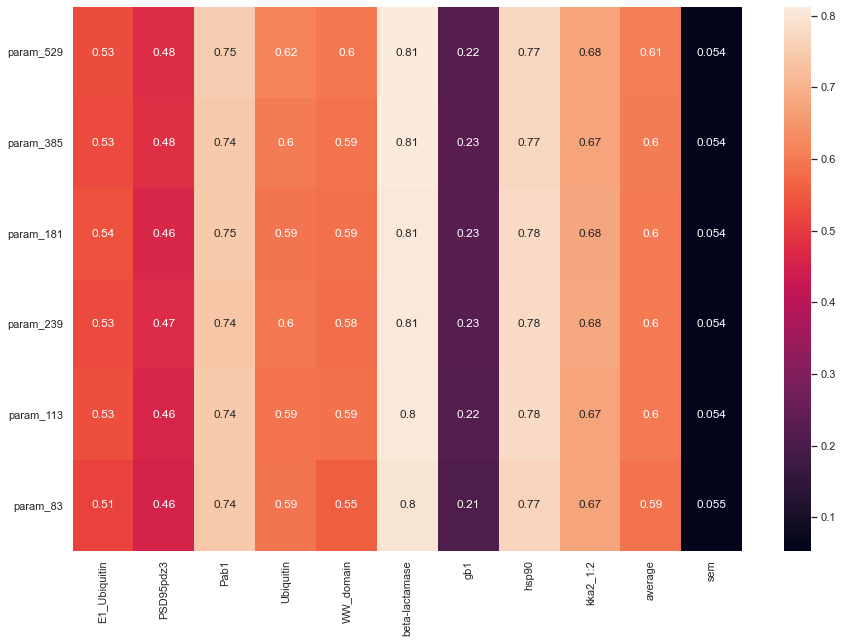

In [26]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_df.iloc[::100], annot=True)
_ = plt.yticks(rotation=0)

In [27]:
params_random_search[529]

{'max_depth': 6,
 'min_child_weight': 0.5,
 'subsample': 0.4,
 'colsample_bytree': 0.5,
 'eta': 0.019,
 'tree_method': 'hist',
 'objective': 'reg:squarederror',
 'nthread': 1,
 'gamma': 0.3,
 'lambda': 0.01,
 'alpha': 0.08,
 'num_rounds': 1000}

## Plotting the results with a specific set of hyperparams

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
import joblib

def plot_results(df_results):
    for curr_dataset in set(df_results.dms_id):
        for kind in ['validation', 'test']:
            y_pred = df_results[(df_results.dms_id == curr_dataset) & (df_results.kind == kind)].y_pred
            y_true = df_results[(df_results.dms_id == curr_dataset) & (df_results.kind == kind)].y_true
            is_wt = df_results[(df_results.dms_id == curr_dataset) & (df_results.kind == kind)].is_wt
            print('{} performance for dataset: {}'.format(kind, curr_dataset))
            print('test pearson:', stats.pearsonr(y_pred, y_true)[0])
            print('test spearman:', stats.spearmanr(y_pred, y_true)[0])
            print('test kendall:', stats.kendalltau(y_pred, y_true)[0])
            plt.close()
            sns.scatterplot(x=y_true[~is_wt],
                            y=y_pred[~is_wt],
                            marker='x')
            sns.scatterplot(x=y_true[is_wt],
                            y=y_pred[is_wt],
                            s=100,
                            alpha=0.5)
            plt.show()

dump_in = joblib.load('/home/saul/master_thesis_work/processing/dms/single_protein_models/by_position/validation_and_test_20210429-214356.joblib.xz')
df_results = dump_in['data']
params = dump_in['params']
del dump_in
len(df_results)

21842

validation performance for dataset: beta-lactamase
test pearson: 0.8091506004372412
test spearman: 0.7874737489733067
test kendall: 0.5865605107768811


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


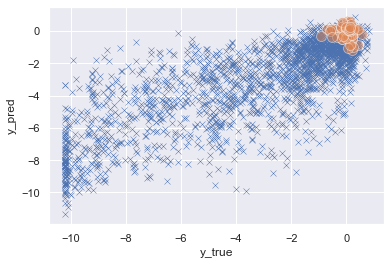

test performance for dataset: beta-lactamase
test pearson: 0.8192975564928004
test spearman: 0.7614364859351752
test kendall: 0.5679908786913888


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


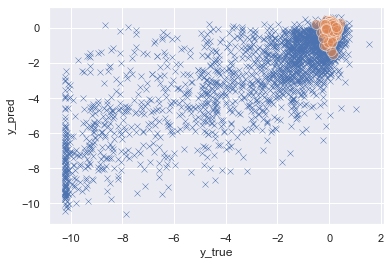

validation performance for dataset: kka2_1:2
test pearson: 0.6721382661397722
test spearman: 0.6708190228103124
test kendall: 0.47166724020517103


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


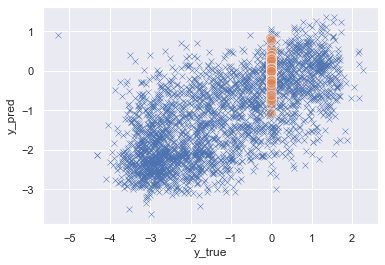

test performance for dataset: kka2_1:2
test pearson: 0.6798535830898813
test spearman: 0.6795193014348353
test kendall: 0.4798784153215918


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


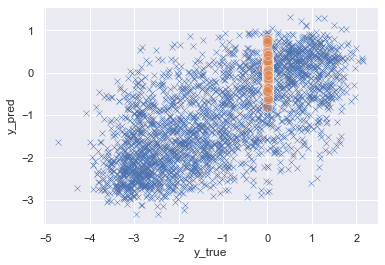

validation performance for dataset: Ubiquitin
test pearson: 0.6001407782048179
test spearman: 0.5640671954183208
test kendall: 0.4002942914156279


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


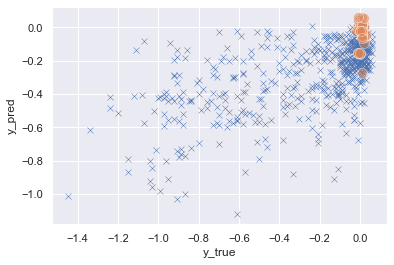

/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


test performance for dataset: Ubiquitin
test pearson: 0.3432143052828206
test spearman: 0.3795676181642411
test kendall: 0.26666220750213204


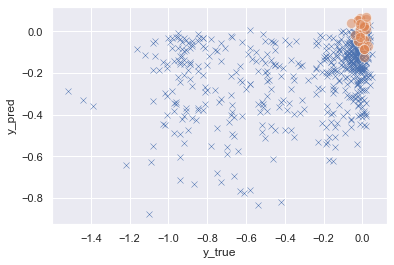

validation performance for dataset: WW_domain
test pearson: 0.5772203614216184
test spearman: 0.6052575717372353
test kendall: 0.4169212690951822


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


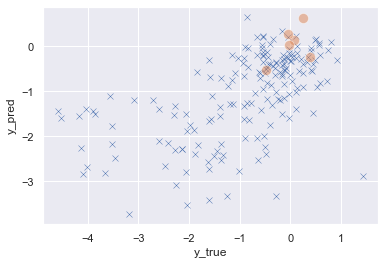

test performance for dataset: WW_domain
test pearson: 0.685606786681981
test spearman: 0.6489370732174237
test kendall: 0.45613835476163384


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


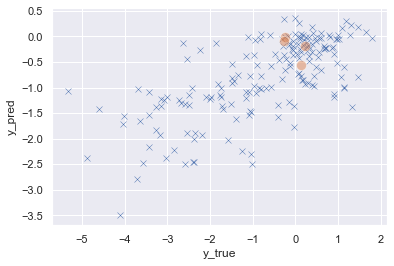

validation performance for dataset: hsp90
test pearson: 0.7683495594971741
test spearman: 0.5398875359152396
test kendall: 0.3808779594864801


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


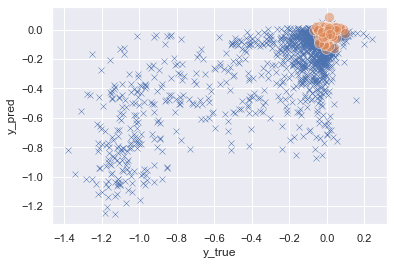

test performance for dataset: hsp90
test pearson: 0.6523127607211248
test spearman: 0.47701440224155967
test kendall: 0.33310110288027917


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


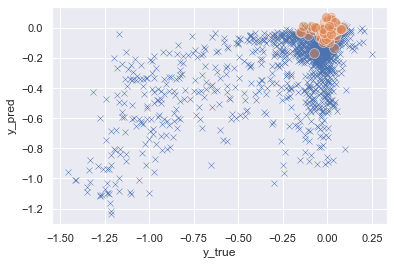

validation performance for dataset: Pab1
test pearson: 0.7424349598289586
test spearman: 0.6250305652529918
test kendall: 0.43694833898352115


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


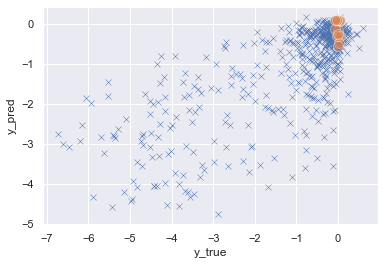

test performance for dataset: Pab1
test pearson: 0.6988750305673528
test spearman: 0.6411270575785549
test kendall: 0.45162473121236096


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


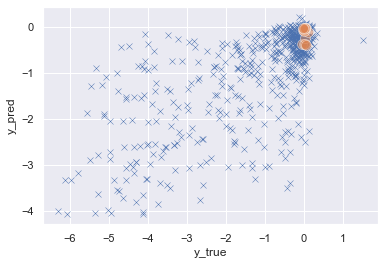

validation performance for dataset: gb1
test pearson: 0.2357166877043609
test spearman: 0.2350608848050128
test kendall: 0.16061379652323604


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


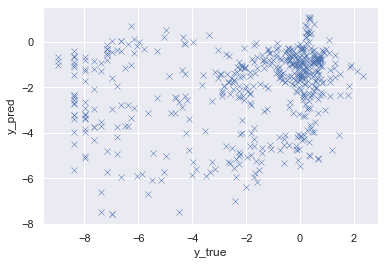

test performance for dataset: gb1
test pearson: 0.24103098838877413
test spearman: 0.23772359389394873
test kendall: 0.16562247138632832


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


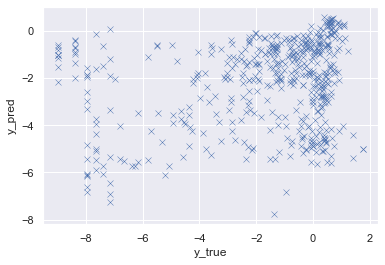

validation performance for dataset: PSD95pdz3
test pearson: 0.46811976533578015
test spearman: 0.3626880159975546
test kendall: 0.24435391121992878


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


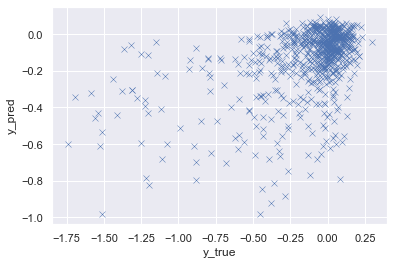

test performance for dataset: PSD95pdz3
test pearson: 0.5978759255494104
test spearman: 0.6153227398125137
test kendall: 0.4351773379733645


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


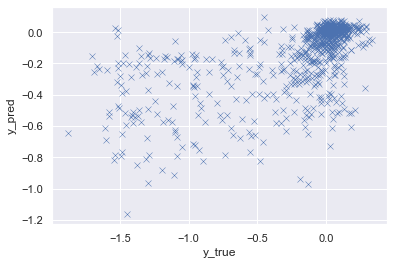

validation performance for dataset: E1_Ubiquitin
test pearson: 0.514568363841038
test spearman: 0.326997664926021
test kendall: 0.21783401133548794


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


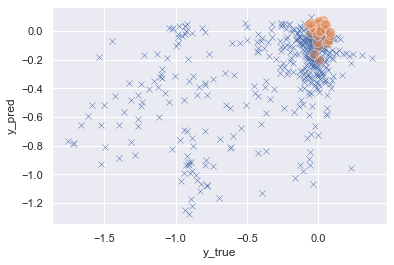

test performance for dataset: E1_Ubiquitin
test pearson: 0.5544768566525361
test spearman: 0.3697168823158089
test kendall: 0.25451271857040453


/usr/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


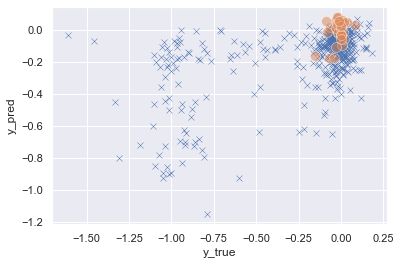

In [2]:
plot_results(df_results)